In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import rasterio
import geopandas as gpd

# Losses

https://nfipservices.floodsmart.gov/reports-flood-insurance-data

* Claims by Occupancy Type/Zone

Restrict to 1 to 4 Unit Residential to represent Owner Occupied 

In [5]:
loss_stats_df = pd.read_csv('s3://sagemaker-us-east-1-565022919370/flood/loss_statistics.csv', skipinitialspace = True, converters={'Losses - Single Family ': str.strip})
loss_stats_df.columns

Index(['State', 'Rated Flood Zones', 'Losses - Single Family ',
       'Payments - Single Family ', 'Losses - 2-4 Family ',
       'Payments - 2-4 Family ', 'Losses - Other Residential ',
       'Payments - Other Residential ',
       'Losses - Non-Residential Small Business ',
       'Payments - Non-Residential Small Business ',
       'Losses - Non-Residential Non-Small Business ',
       'Payments - Non-Residential Non-Small Business ',
       'Losses - Non-Business Non-Residential ',
       'Payments - Non-Business Non-Residential ', 'Losses - Unknown ',
       'Payments - Unknown '],
      dtype='object')

In [6]:
%%time

loss_stats_df = loss_stats_df.replace({
    '-   ': '0',
    '$-   ': '0',  
    '-': '0'
}).copy()

loss_stats_df['Losses - Single Family '] = loss_stats_df['Losses - Single Family '].str.replace(',','').astype(float)
loss_stats_df['Losses - 2-4 Family '] = loss_stats_df['Losses - 2-4 Family '].str.replace(',','').astype(float)

loss_stats_df['Payments - Single Family '] = loss_stats_df['Payments - Single Family '].str.replace('$','').str.replace(',','').str.strip().astype(float)
loss_stats_df['Payments - 2-4 Family '] = loss_stats_df['Payments - 2-4 Family '].str.replace('$','').str.replace(',','').str.strip().astype(float)



md_losses_df = loss_stats_df.loc[
    (loss_stats_df.State == 'MARYLAND'),
    ['State', 'Rated Flood Zones', 'Losses - Single Family ', 'Payments - Single Family ', 'Losses - 2-4 Family ', 'Payments - 2-4 Family ']
]

md_losses_df['Total_Losses'] = md_losses_df['Losses - Single Family '] + md_losses_df['Losses - 2-4 Family ']
md_losses_df['Total_Payments'] = md_losses_df['Payments - Single Family '] + md_losses_df['Payments - 2-4 Family ']
md_losses_df['Avg_Pmt_Per_Loss'] = md_losses_df['Total_Payments'] / md_losses_df['Total_Losses']

md_losses_df

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 13.3 ms


<timed exec>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
<timed exec>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,State,Rated Flood Zones,Losses - Single Family,Payments - Single Family,Losses - 2-4 Family,Payments - 2-4 Family,Total_Losses,Total_Payments,Avg_Pmt_Per_Loss
205,MARYLAND,A,1728.0,21538860.0,28.0,139502.0,1756.0,21678362.0,12345.308656
206,MARYLAND,AE,8792.0,151110590.0,330.0,5290721.0,9122.0,156401311.0,17145.506578
207,MARYLAND,AH,20.0,433833.0,0.0,0.0,20.0,433833.0,21691.650000
208,MARYLAND,AO,9.0,40033.0,4.0,17596.0,13.0,57629.0,4433.000000
209,MARYLAND,BLANK,54.0,306960.0,0.0,0.0,54.0,306960.0,5684.444444
210,MARYLAND,D,11.0,30560.0,0.0,0.0,11.0,30560.0,2778.181818
211,MARYLAND,EMG,5181.0,1657062.0,25.0,36242.0,5206.0,1693304.0,325.260085
212,MARYLAND,V,1.0,199.0,0.0,0.0,1.0,199.0,199.000000
213,MARYLAND,VE,223.0,2373995.0,22.0,93906.0,245.0,2467901.0,10073.065306
214,MARYLAND,X,5022.0,42467915.0,142.0,1365175.0,5164.0,43833090.0,8488.204880


## Calculate

1. Total Losses in the state

2. Total Payments in the state

3. Average Payment Per Loss state level

* It would be interesting if we could map baltimore county's distribution of the Flood Zones to this data and therefore get a expected loss that is sensitve to flood zone.

In [7]:
md_total_losses = md_losses_df.Total_Losses.sum()
md_total_losses

21592.0

In [8]:
md_total_payments = md_losses_df.Total_Payments.sum()
md_total_payments

226903149.0

In [9]:
total_avg_pmt_per_loss = md_losses_df.Total_Payments.sum() / md_losses_df.Total_Losses.sum()
total_avg_pmt_per_loss

10508.667515746572

# County Attribution

https://www.fema.gov/data-visualization/historical-flood-risk-and-costs

Select Maryland and Download All the Data From the Tableau Graphic

In [10]:
state_map_full_df =pd.read_csv('s3://sagemaker-us-east-1-565022919370/flood/State_Map_Full_Data_data.csv', skipinitialspace = True)

state_map_full_df.head()

,County,State,Total Floods (group),Number of Floods,State:,Year,Average Claims Payment,Average IHP Payment,Total Floods
0,PRINCE GEORGES,MARYLAND,20-Nov,0,MARYLAND,1996,22216.05,3507,14
1,CHARLES,MARYLAND,50+,0,MARYLAND,1996,22216.05,3507,66
2,QUEEN ANNE'S,MARYLAND,50+,0,MARYLAND,1996,22216.05,3507,66
3,WORCESTER,MARYLAND,31-40,2,MARYLAND,1996,22216.05,3507,32
4,CALVERT,MARYLAND,50+,2,MARYLAND,1996,22216.05,3507,61


<AxesSubplot:xlabel='Year'>

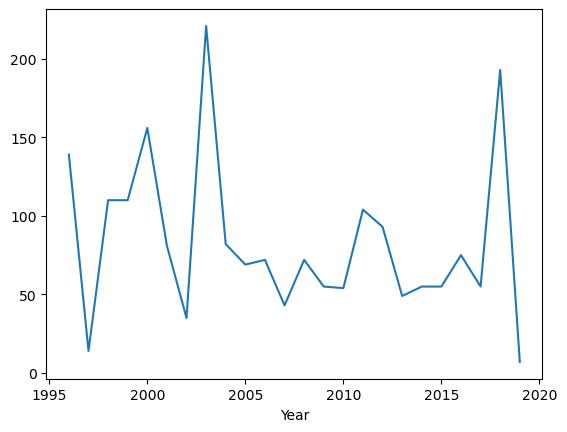

In [11]:
state_map_full_df.groupby(['Year'])['Number of Floods'].sum().plot()

<AxesSubplot:xlabel='Year'>

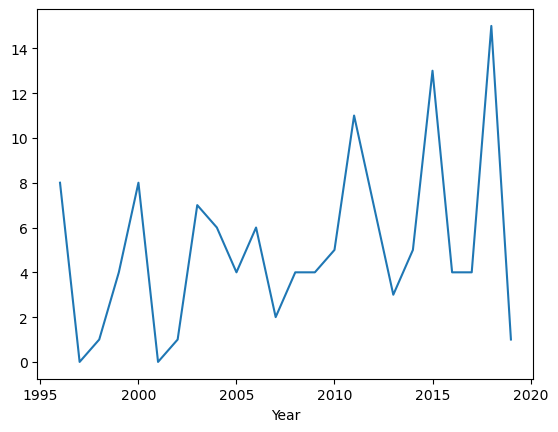

In [12]:
### Flood Events Have been increasing in Baltimore County 
state_map_full_df.loc[
    state_map_full_df.County == 'BALTIMORE',
    ['Year', 'Number of Floods']
].groupby(['Year'])['Number of Floods'].sum().plot()

<AxesSubplot:xlabel='Year'>

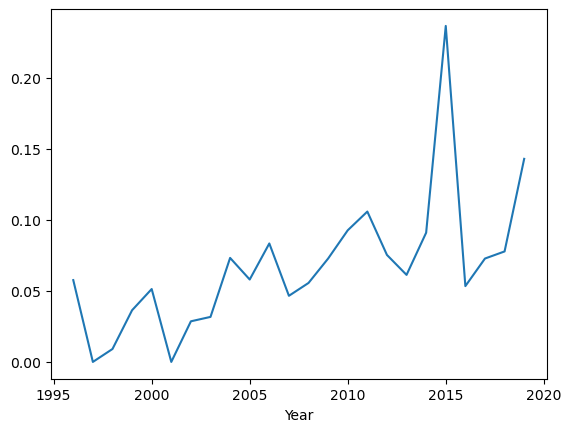

In [13]:
# Flood Events have also been increasing relative to the rest of the state
(state_map_full_df.loc[
    state_map_full_df.County == 'BALTIMORE',
    ['Year', 'Number of Floods']
].groupby('Year')['Number of Floods'].sum() / state_map_full_df.groupby(['Year'])['Number of Floods'].sum()).plot()

### Proportion of Floods By County for all data 

From 1996 to 2019

Baltimore County has ~6% of the states flood events

In [14]:

county_percentage_of_floods = state_map_full_df.groupby(['County'])['Number of Floods'].sum() / state_map_full_df['Number of Floods'].sum()

baltimore_pct_floods = county_percentage_of_floods['BALTIMORE']

county_percentage_of_floods

County
ALLEGANY           0.032016
ANNE ARUNDEL       0.075538
BALTIMORE          0.061531
CALVERT            0.030515
CAROLINE           0.038019
CARROLL            0.047524
CECIL              0.057029
CHARLES            0.033017
DORCHESTER         0.018009
FREDERICK          0.071536
GARRETT            0.030515
HARFORD            0.048024
HOWARD             0.051026
KENT               0.036018
MONTGOMERY         0.083042
PRINCE GEORGE'S    0.052026
PRINCE GEORGES     0.007004
QUEEN ANNE'S       0.033017
QUEEN ANNES        0.012006
SOMERSET           0.013507
ST. MARY'S         0.057529
TALBOT             0.040020
WASHINGTON         0.041021
WICOMICO           0.014507
WORCESTER          0.016008
Name: Number of Floods, dtype: float64

In [15]:
baltimore_pct_floods

0.061530765382691345

From 2011 to 2019

Baltimore County has ~9% of the states flood events

In [16]:
county_percentage_of_floods_2011p = state_map_full_df.loc[
    state_map_full_df['Year'] >= 2011
].groupby(['County'])['Number of Floods'].sum() / state_map_full_df.loc[
    state_map_full_df['Year'] >= 2011
]['Number of Floods'].sum()

baltimore_pct_floods_2011p = county_percentage_of_floods_2011p['BALTIMORE']

county_percentage_of_floods_2011p

County
ALLEGANY           0.023324
ANNE ARUNDEL       0.097668
BALTIMORE          0.091837
CALVERT            0.027697
CAROLINE           0.021866
CARROLL            0.037901
CECIL              0.040816
CHARLES            0.026239
DORCHESTER         0.030612
FREDERICK          0.065598
GARRETT            0.018950
HARFORD            0.048105
HOWARD             0.046647
KENT               0.024781
MONTGOMERY         0.078717
PRINCE GEORGE'S    0.058309
PRINCE GEORGES     0.002915
QUEEN ANNE'S       0.032070
QUEEN ANNES        0.010204
SOMERSET           0.024781
ST. MARY'S         0.081633
TALBOT             0.027697
WASHINGTON         0.030612
WICOMICO           0.021866
WORCESTER          0.029155
Name: Number of Floods, dtype: float64

In [17]:
baltimore_pct_floods_2011p

0.09183673469387756

# Attribution of Losses/Payments to Baltimore

This is meaningless and is just here as a placeholder as if we had a flood zone level distribution for baltimore county

In [18]:
baltimore_losses = baltimore_pct_floods * md_total_losses 
baltimore_losses

1328.5722861430716

In [19]:
baltimore_payments = baltimore_pct_floods * md_total_payments
baltimore_payments

13961524.425712856

In [20]:
baltimore_payments / baltimore_losses

10508.667515746572

# Baltimore Housing Data

https://www.census.gov/quickfacts/fact/table/baltimorecountymaryland/PST045222

In [21]:
number_of_households = 351142
OO_households = 0.665
median_prop_value = 277500


number_of_OO_households = number_of_households * OO_households
total_prop_value_OO = median_prop_value * number_of_OO_households

total_prop_value_OO

64798866825.00001

# Loss as a Percent of Property Value

In [22]:
loss_as_pct_property_value = total_avg_pmt_per_loss / median_prop_value

loss_as_pct_property_value

0.037869072128816475

### Property Level Data

In [23]:
bc_count_real_assessment = pd.read_csv('s3://sagemaker-us-east-1-565022919370/baltimore_county/Baltimore_County_Real_Property_Assessments__Hidden_Property_Owner_Names.csv') 

/tmp/ipykernel_6525/3195086203.py:1: DtypeWarning: Columns (25,29,31,41,48,63,64,65,66,78,119,120,128,129,165,166,172,205,211,212,214) have mixed types. Specify dtype option on import or set low_memory=False.
  bc_count_real_assessment = pd.read_csv('s3://sagemaker-us-east-1-565022919370/baltimore_county/Baltimore_County_Real_Property_Assessments__Hidden_Property_Owner_Names.csv')


In [24]:
pd.options.display.max_columns = None
bc_count_real_assessment.head()

,Jurisdiction Code (MDP Field: JURSCODE),County Name (MDP Field: CNTYNAME),Account ID (MDP Field: ACCTID),Real Property Search Link,FINDER Online Link,Search Google Maps for this Location,MDP Longitude (MDP Field: DIGXCORD converted to WGS84),MDP Latitude (MDP Field: DIGYCORD converted to WGS84),Mappable Latitude and Longitude,RECORD KEY: County Code (SDAT Field #1),RECORD KEY: District/Ward (SDAT Field #2),RECORD KEY: Account Number (SDAT Field #3),RECORD KEY: Subdistrict (SDAT Field #4),RECORD KEY: Geographic Code (MDP Field: GEOGCODE. SDAT Field #5),RECORD KEY: Owner Occupancy Code (MDP Field: OOI. SDAT Field #6),LEGAL DESCRIPTION: Line 1 (MDP Field: LEGAL1. SDAT Field #17),LEGAL DESCRIPTION: Line 2 (MDP Field: LEGAL2. SDAT Field #18),LEGAL DESCRIPTION: Line 3 (MDP Field: LEGAL3. SDAT Field #19),MdProperty View Edition Year (MDP Field: EXISTING),MDP Street Address (MDP Field: ADDRESS),MDP Street Address City (MDP Field: CITY),MDP Street Address Zip Code (MDP Field: ZIPCODE),MDP Street Address Units (MDP Field: STRTUNT),PREMISE ADDRESS: Number (MDP Field: PREMSNUM. SDAT Field #20),PREMISE ADDRESS: Number Suffix (SDAT Field #21),PREMISE ADDRESS: Direction (MDP Field: PREMSDIR. SDAT Field #22),PREMISE ADDRESS: Name (MDP Field: PREMSNAM. SDAT Field #23),PREMISE ADDRESS: Type (MDP Field: PREMSTYP. SDAT Field #24),PREMISE ADDRESS: City (MDP Field: PREMCITY. SDAT Field #25),PREMISE ADDRESS: Zip Code (MDP Field: PREMZIP. SDAT Field #26),PREMISE ADDRESS: Zip +4 Code (MDP Field: PREMZIP2. SDAT Field #27),PREMISE ADDRESS: Condominium Unit No. (SDAT Field #28),DEED REFERENCE 1: Clerk Initials (MDP Field: DR1CLERK. SDAT Field #29),DEED REFERENCE 1: Liber (MDP Field: DR1LIBER. SDAT Field #30),DEED REFERENCE 1: Folio (MDP Field: DR1FOLIO. SDAT Field #31),Town Code (MDP Field: TOWNCODE/DESCTOWN. SDAT Field #36),Subdivision Code (MDP Field: SUBDIVSN. SDAT Field #37),Plat Number (MDP Field: PLAT. SDAT Field #38),Section (MDP Field: SECTION. SDAT Field #39),Block (MDP Field: BLOCK. SDAT Field #40),Lot (MDP Field: LOT. SDAT Field #41),Map (MDP Field: MAP. SDAT Field #42),Grid (MDP Field: GRID. SDAT Field #43),Parcel (MDP Field: PARCEL. SDAT Field #44),Zoning Code (MDP Field: ZONING. SDAT Field #45),Exempt Class (MDP Field: EXCLASS/DESCEXCL. SDAT Field #49),MDP Street Address Type Code (MDP Field: RESITYP),Land Use Code (MDP Field: LU/DESCLU. SDAT Field #50),Multi-Parent Account Ind. (SDAT Field #55),County System Property Code (SDAT Field #56),County Service Code (SDAT Field #57),Tax Class (SDAT Field #58),Municipal Tax Class (SDAT Field #59),Recreational Influence Ind. (MDP Field: RECIND. SDAT Field #60),BPRUC (Public Use Code) (MDP Field: CIUSE/DESCCIUSE. SDAT Field #61),Ad Valorem Code (SDAT Field #62),PROPERTY FACTORS: Utilities - Water (MDP Field: PFUW. SDAT Field #63),PROPERTY FACTORS: Utilities - Sewer (MDP Field: PFUS. SDAT Field #64),PROPERTY FACTORS: Location - Waterfront (MDP Field: PFLW. SDAT Field #65),PROPERTY FACTORS: Street - Paved (MDP Field: PFSP. SDAT Field #67),PROPERTY FACTORS: Street - Unpaved (MDP Field: PFSU. SDAT Field #68),PROPERTY FACTORS: Influence - Commer/Indust. (MDP Field: PFIC. SDAT Field #69),PROPERTY FACTORS: Influence - Historical (MDP Field: PFIH. SDAT Field #70),FIELD CARD NUMBER: Field Card No. Primary (MDP Field: FCRD1ST5. SDAT Field #75),FIELD CARD NUMBER: Field Card No. Secondary (MDP Field: FCRDNXT3. SDAT Field #76),FIELD CARD NUMBER: Field Card No. Subset 3 (MDP Field: FCRDNXT2. SDAT Field #77),FIELD CARD NUMBER: Field Card No. Subset 4 (MDP Field: FCRDLST2. SDAT Field #78),SALES SEGMENT 1: Transfer Number (MDP Field: TRANSNO1. SDAT Field #79),SALES SEGMENT 1: Grantor Name (MDP Field: GRNTNAM1. SDAT Field #80),SALES SEGMENT 1: Grantor Deed Reference 1 - Clerk Initials (MDP Field: GR1CLRK1. SDAT Field #81),SALES SEGMENT 1: Grantor Deed Reference 1 - Liber (MDP Field: GR1LIBR1. SDAT Field #82),SALES SEGMENT 1: Grantor Deed Reference 1 - Folio (MDP Field: GR1FOLO1. SDAT Field #83),SALES SEGMENT 1: How C

### Interesting that the total assessment value for ownder occupied is very close to the backed into amount above

In [25]:
bc_count_real_assessment['RECORD KEY: Owner Occupancy Code (MDP Field: OOI. SDAT Field #6)'].value_counts(normalize=True)

H    0.690968
N    0.300696
D    0.008336
Name: RECORD KEY: Owner Occupancy Code (MDP Field: OOI. SDAT Field #6), dtype: float64

In [26]:
bc_county_realty_assess_data_filter_df = bc_count_real_assessment[
    [
        'Mappable Latitude and Longitude', 
        'MDP Longitude (MDP Field: DIGXCORD converted to WGS84)', 
        'MDP Latitude (MDP Field: DIGYCORD converted to WGS84)',
        'MDP Street Address (MDP Field: ADDRESS)', 
        'MDP Street Address City (MDP Field: CITY)', 
        'MDP Street Address Zip Code (MDP Field: ZIPCODE)',         
        'RECORD KEY: Owner Occupancy Code (MDP Field: OOI. SDAT Field #6)',        
        'CURRENT ASSESSMENT YEAR: Total Assessment (SDAT Field #172)',
        'Land Use Code (MDP Field: LU/DESCLU. SDAT Field #50)',
        'CURRENT CYCLE DATA: Date Assessed (YYYY.MM) (MDP Field: LASTASSD. SDAT Field #169)',
    ]
].rename(columns = {
    'Mappable Latitude and Longitude' : 'lat_lon', 
    'MDP Longitude (MDP Field: DIGXCORD converted to WGS84)': 'longitude', 
    'MDP Latitude (MDP Field: DIGYCORD converted to WGS84)' : 'latitude',
    'MDP Street Address (MDP Field: ADDRESS)': 'address', 
    'MDP Street Address City (MDP Field: CITY)': 'city', 
    'MDP Street Address Zip Code (MDP Field: ZIPCODE)': 'zipcode',         
    'Land Use Code (MDP Field: LU/DESCLU. SDAT Field #50)':'Land_Use_Code',
    'RECORD KEY: Owner Occupancy Code (MDP Field: OOI. SDAT Field #6)': 'oo_code',        
    'CURRENT ASSESSMENT YEAR: Total Assessment (SDAT Field #172)': 'assessment_value',
    'CURRENT CYCLE DATA: Date Assessed (YYYY.MM) (MDP Field: LASTASSD. SDAT Field #169)': 'Current_Date_Assessed', 
}).copy()


bc_county_realty_assess_data_filter_oo_df = bc_county_realty_assess_data_filter_df.loc[
    (~bc_county_realty_assess_data_filter_df.lat_lon.isna()) &
    (~bc_county_realty_assess_data_filter_df.address.isna()) & 
    (~bc_county_realty_assess_data_filter_df.zipcode.isna()) &
    (~bc_county_realty_assess_data_filter_df.Land_Use_Code.isna()) &
    (~bc_county_realty_assess_data_filter_df.assessment_value.isna()) &
    (bc_county_realty_assess_data_filter_df.oo_code == 'H') &
    (bc_county_realty_assess_data_filter_df['Land_Use_Code'] == "Residential (R)")
].copy()

bc_county_realty_assess_data_filter_oo_df['Current_Date_Assessed'] = bc_county_realty_assess_data_filter_oo_df['Current_Date_Assessed'].astype(float)  

bc_county_realty_assess_data_filter_oo_df.loc[
        bc_county_realty_assess_data_filter_oo_df.Current_Date_Assessed >= 2022
]

bc_county_realty_assess_data_filter_oo_df['severity_given_flood'] = loss_as_pct_property_value

bc_county_realty_assess_data_filter_oo_df.head()

,lat_lon,longitude,latitude,address,city,zipcode,oo_code,assessment_value,Land_Use_Code,Current_Date_Assessed,severity_given_flood
0,"(39.29843552027323, -76.7478994452805)",-76.747899,39.298436,6542 REDGATE CIR,CATONSVILLE,21228.0,H,254400.0,Residential (R),2022.01,0.037869
1,"(39.27665709720897, -76.73443688977927)",-76.734437,39.276657,715 EDMONDSON AVE,CATONSVILLE,21228.0,H,411900.0,Residential (R),2022.01,0.037869
2,"(39.277031599751744, -76.71512505843127)",-76.715125,39.277032,7 N SYMINGTON AVE,CATONSVILLE,21228.0,H,201200.0,Residential (R),2022.01,0.037869
3,"(39.28505026124913, -76.71221254103799)",-76.712213,39.285050,132 WESTOWNE PL,BALTIMORE,21229.0,H,199600.0,Residential (R),2022.01,0.037869
4,"(39.27804617190546, -76.72240509291373)",-76.722405,39.278046,43 DUNGARRIE RD,CATONSVILLE,21228.0,H,399100.0,Residential (R),2022.01,0.037869


In [27]:
bc_county_realty_assess_data_filter_oo_df.Current_Date_Assessed.value_counts()

2021.01    70770
2022.01    61679
2023.01    60302
2019.01        2
2016.01        1
Name: Current_Date_Assessed, dtype: int64

In [28]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
bc_county_realty_assess_data_filter_oo_df.groupby(['oo_code'])['assessment_value'].sum()

oo_code
H   60656447660.000
Name: assessment_value, dtype: float64

testing fuzzing join

In [41]:
bc_county_realty_assess_data_filter_oo_gdf = gpd.GeoDataFrame(
    bc_county_realty_assess_data_filter_oo_df, 
    geometry = gpd.points_from_xy(
        bc_county_realty_assess_data_filter_oo_df.longitude, 
        bc_county_realty_assess_data_filter_oo_df.latitude, 
        crs = 'EPSG:4326'
    )

)

bc_county_realty_assess_data_filter_oo_gdf.head()

,lat_lon,longitude,latitude,address,city,zipcode,oo_code,assessment_value,Land_Use_Code,Current_Date_Assessed,severity_given_flood,geometry
0,"(39.29843552027323, -76.7478994452805)",-76.748,39.298,6542 REDGATE CIR,CATONSVILLE,21228.000,H,254400.000,Residential (R),2022.010,0.038,POINT (-76.74790 39.29844)
1,"(39.27665709720897, -76.73443688977927)",-76.734,39.277,715 EDMONDSON AVE,CATONSVILLE,21228.000,H,411900.000,Residential (R),2022.010,0.038,POINT (-76.73444 39.27666)
2,"(39.277031599751744, -76.71512505843127)",-76.715,39.277,7 N SYMINGTON AVE,CATONSVILLE,21228.000,H,201200.000,Residential (R),2022.010,0.038,POINT (-76.71513 39.27703)
3,"(39.28505026124913, -76.71221254103799)",-76.712,39.285,132 WESTOWNE PL,BALTIMORE,21229.000,H,199600.000,Residential (R),2022.010,0.038,POINT (-76.71221 39.28505)
4,"(39.27804617190546, -76.72240509291373)",-76.722,39.278,43 DUNGARRIE RD,CATONSVILLE,21228.000,H,399100.000,Residential (R),2022.010,0.038,POINT (-76.72241 39.27805)


In [42]:
svi_df = gpd.read_file('presence_w_svi.csv', ignore_geometry=True)

svi_df['geometry'] = gpd.GeoSeries.from_wkt(svi_df['geometry'])

svi_gdf = gpd.GeoDataFrame(svi_df)

svi_gdf = svi_gdf.set_crs(crs='EPSG:4269')

svi_gdf = svi_gdf.rename(columns={'Raster Value': 'SVI'})[['geometry', 'SVI']]

svi_gdf.head()

,geometry,SVI
0,POINT (-98.35000 47.85650),0.5299
1,POINT (-86.97000 39.03000),0.9253
2,POINT (-83.92000 40.48000),0.6858
3,POINT (-86.40000 38.77000),0.909
4,POINT (-85.90000 38.99890),0.2364


In [43]:
bc_county_realty_assess_data_filter_oo_gdf = bc_county_realty_assess_data_filter_oo_gdf.to_crs('EPSG:3857')
svi_gdf = svi_gdf.to_crs('EPSG:3857')

bc_county_realty_assess_data_filter_oo_gdf = bc_county_realty_assess_data_filter_oo_gdf.sjoin_nearest(
    svi_gdf, 
    how="left", 
    distance_col='Distances'
)

In [44]:
%%time


bucket='sagemaker-us-east-1-565022919370/Output_CONUS_FDP_100m'
data_key = 'CONUS_FDP_100m.tif'
data_location = 's3://{}/{}'.format(bucket, data_key)
predictions_src = rasterio.open(data_location)


# merge predictions with presence file
bc_county_realty_assess_data_filter_oo_gdf['geometry'] = bc_county_realty_assess_data_filter_oo_gdf.geometry.to_crs('5070')
bc_county_realty_assess_data_filter_oo_gdf.index = range(len(bc_county_realty_assess_data_filter_oo_gdf))
coords = [
    (x,y) for x, y in zip(bc_county_realty_assess_data_filter_oo_gdf.geometry.x, bc_county_realty_assess_data_filter_oo_gdf.geometry.y)
]
# Sample the raster at every point location and store values in DataFrame
bc_county_realty_assess_data_filter_oo_gdf['Raster Value'] = [x for x in predictions_src.sample(coords)]
bc_county_realty_assess_data_filter_oo_gdf['Raster Value'] = bc_county_realty_assess_data_filter_oo_gdf.apply(
    lambda x: x['Raster Value'][0], axis=1
)

bc_county_realty_assess_data_filter_oo_gdf = bc_county_realty_assess_data_filter_oo_gdf.rename(
    columns = {'Raster Value': 'FDP'}
)


bc_county_realty_assess_data_filter_oo_gdf['SVI'] = bc_county_realty_assess_data_filter_oo_gdf.SVI.astype(float)

bc_county_realty_assess_data_filter_oo_gdf = bc_county_realty_assess_data_filter_oo_gdf.loc[
    (bc_county_realty_assess_data_filter_oo_gdf.SVI >= 0)
    &
    (bc_county_realty_assess_data_filter_oo_gdf.FDP >= 0),
]

bc_county_realty_assess_data_filter_oo_gdf

CPU times: user 11.7 s, sys: 269 ms, total: 12 s
Wall time: 30.5 s


,lat_lon,longitude,latitude,address,city,zipcode,oo_code,assessment_value,Land_Use_Code,Current_Date_Assessed,severity_given_flood,geometry,index_right,SVI,Distances,FDP
0,"(39.29843552027323, -76.7478994452805)",-76.748,39.298,6542 REDGATE CIR,CATONSVILLE,21228.000,H,254400.000,Residential (R),2022.010,0.038,POINT (1633860.977 1974422.973),27255,0.131,907.704,0.494
1,"(39.27665709720897, -76.73443688977927)",-76.734,39.277,715 EDMONDSON AVE,CATONSVILLE,21228.000,H,411900.000,Residential (R),2022.010,0.038,POINT (1635479.244 1972263.660),30690,0.490,808.023,0.517
2,"(39.277031599751744, -76.71512505843127)",-76.715,39.277,7 N SYMINGTON AVE,CATONSVILLE,21228.000,H,201200.000,Residential (R),2022.010,0.038,POINT (1637087.638 1972637.284),25410,0.066,609.505,0.541
3,"(39.28505026124913, -76.71221254103799)",-76.712,39.285,132 WESTOWNE PL,BALTIMORE,21229.000,H,199600.000,Residential (R),2022.010,0.038,POINT (1637150.328 1973567.713),25410,0.066,848.673,0.559
4,"(39.27804617190546, -76.72240509291373)",-76.722,39.278,43 DUNGARRIE RD,CATONSVILLE,21228.000,H,399100.000,Residential (R),2022.010,0.038,POINT (1636455.231 1972623.276),25410,0.066,1337.479,0.510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192749,"(39.36439107154083, -76.41080917302111)",-76.411,39.364,10644 WENNINGTON ST,BALTIMORE,21220.000,H,694500.000,Residential (R),2021.010,0.038,POINT (1660552.998 1987503.884),19917,0.280,2227.903,0.276
192750,"(39.364450669710386, -76.41083884784885)",-76.411,39.364,10646 WENNINGTON ST,BALTIMORE,21220.000,H,707400.000,Residential (R),2021.010,0.038,POINT (1660549.151 1987509.903),19917,0.280,2227.189,0.324
192751,"(39.364751339319156, -76.41098255885348)",-76.411,39.365,10656 WENNINGTON ST,BALTIMORE,21220.000,H,729200.000,Residential (R),2021.010,0.038,POINT (1660530.245 1987540.376),19917,0.280,2224.801,0.324
192752,"(39.36451116277093, -76.41086735488652)",-76.411,39.365,10647 WENNINGTON ST,BALTIMORE,21220.000,H,654700.000,Residential (R),2021.010,0.038,POINT (1660545.381 1987516.041),19917,0.280,2226.676,0.324


In [45]:
bc_county_realty_assess_data_filter_oo_gdf['SVI'] = bc_county_realty_assess_data_filter_oo_gdf.SVI.astype(float)

bc_county_realty_assess_data_filter_oo_gdf = bc_county_realty_assess_data_filter_oo_gdf.loc[
    (bc_county_realty_assess_data_filter_oo_gdf.SVI >= 0)
    &
    (bc_county_realty_assess_data_filter_oo_gdf.FDP >= 0),
]

In [47]:
bc_county_realty_assess_data_filter_oo_gdf.head()

,lat_lon,longitude,latitude,address,city,zipcode,oo_code,assessment_value,Land_Use_Code,Current_Date_Assessed,severity_given_flood,geometry,index_right,SVI,Distances,FDP
0,"(39.29843552027323, -76.7478994452805)",-76.748,39.298,6542 REDGATE CIR,CATONSVILLE,21228.000,H,254400.000,Residential (R),2022.010,0.038,POINT (1633860.977 1974422.973),27255,0.131,907.704,0.494
1,"(39.27665709720897, -76.73443688977927)",-76.734,39.277,715 EDMONDSON AVE,CATONSVILLE,21228.000,H,411900.000,Residential (R),2022.010,0.038,POINT (1635479.244 1972263.660),30690,0.490,808.023,0.517
2,"(39.277031599751744, -76.71512505843127)",-76.715,39.277,7 N SYMINGTON AVE,CATONSVILLE,21228.000,H,201200.000,Residential (R),2022.010,0.038,POINT (1637087.638 1972637.284),25410,0.066,609.505,0.541
3,"(39.28505026124913, -76.71221254103799)",-76.712,39.285,132 WESTOWNE PL,BALTIMORE,21229.000,H,199600.000,Residential (R),2022.010,0.038,POINT (1637150.328 1973567.713),25410,0.066,848.673,0.559
4,"(39.27804617190546, -76.72240509291373)",-76.722,39.278,43 DUNGARRIE RD,CATONSVILLE,21228.000,H,399100.000,Residential (R),2022.010,0.038,POINT (1636455.231 1972623.276),25410,0.066,1337.479,0.510


In [48]:
bc_county_realty_assess_data_filter_oo_gdf['loss_given_flood'] = bc_county_realty_assess_data_filter_oo_gdf['assessment_value'] * bc_county_realty_assess_data_filter_oo_gdf['severity_given_flood']

bc_county_realty_assess_data_filter_oo_gdf['expected_loss'] = bc_county_realty_assess_data_filter_oo_gdf['loss_given_flood'] * bc_county_realty_assess_data_filter_oo_gdf['FDP']

bc_county_realty_assess_data_filter_oo_gdf.expected_loss.describe()

count   191596.000
mean      6146.824
std       4269.835
min          1.136
25%       3755.062
50%       5047.265
75%       7119.216
max     144585.349
Name: expected_loss, dtype: float64

In [58]:
bc_county_realty_assess_data_filter_oo_gdf.loc[
    bc_county_realty_assess_data_filter_oo_gdf.assessment_value <= 726200,
    ['assessment_value', 'expected_loss', 'FDP']
].describe()

,assessment_value,expected_loss,FDP
count,184905.000,184905.000,184905.000
mean,289448.258,5659.830,0.533
std,132419.290,2883.754,0.148
min,100.000,1.136,0.088
25%,195833.000,3713.013,0.425
50%,255600.000,4943.855,0.522
75%,360500.000,6814.457,0.632
max,726200.000,27248.389,1.000


In [89]:
bc_county_realty_assess_data_filter_oo_gdf.shape

(191596, 18)

In [65]:
bc_county_realty_assess_data_filter_oo_gdf.loc[
    bc_county_realty_assess_data_filter_oo_gdf.assessment_value <= 726200,
    ['assessment_value', 'expected_loss', 'FDP']
].sum()

assessment_value   53520430223.000
expected_loss       1046530913.336
FDP                      98488.969
dtype: float64

<AxesSubplot:title={'center':'Distribution of FDP for Baltimore County'}, ylabel='Frequency'>

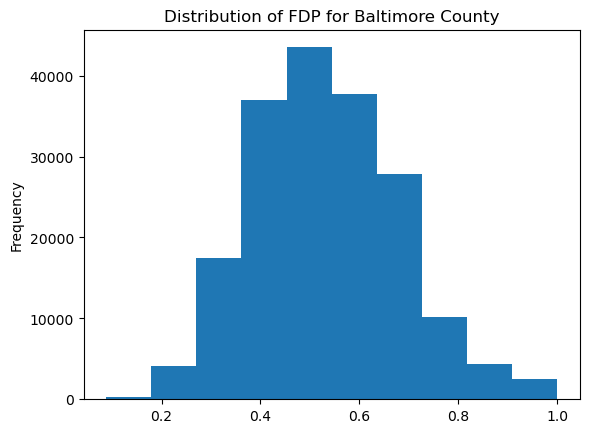

In [88]:
bc_county_realty_assess_data_filter_oo_gdf.loc[
    bc_county_realty_assess_data_filter_oo_gdf.assessment_value <= 726200,
    ['FDP']
].FDP.plot(kind = 'hist', title = 'Distribution of FDP for Baltimore County')